# Phase 4 Project - Time Series Modeling Introduction

### By Rachel Beery

## Overview

### In this notebook we are using a time series model to understand what region of ... We will be using an OpemFEMA Dataset for Disaster Declarations. In the first part of the notebook we will be exploring the aspects of Disaster Declarations so that we can  

Source: https://www.fema.gov/openfema-data-page/disaster-declarations-summaries-v2 

In [90]:
# We will begin by importing all of the packages we anticipate to use
import pandas as pd
import pandas.tseries  
import numpy as np  

import statsmodels.api as sm 
import itertools

import matplotlib.pyplot as plt   
from matplotlib.pylab import rcParams 
%matplotlib inline
plt.style.use('ggplot') 
import plotly.express as px
import plotly.figure_factory as ff 
import plotly.graph_objects as go 
import seaborn as sns  

from statsmodels.tsa.arima_model import ARMA

import warnings
warnings.filterwarnings('ignore') 

In [3]:
# Setting the display defaults
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows',)

# Turning off scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:

#Import data and see the headers
df = pd.read_csv(r"DisasterDeclarationsSummaries.csv")
df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02T04:00:00.000Z,1953,Tornado,TORNADO,0,1,1,1,1953-05-02T04:00:00.000Z,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,2f28952448e0a666d367ca3f854c81ec,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15T04:00:00.000Z,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15T04:00:00.000Z,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,c5a1a4a1030d6730d9c562cdbe7c830f,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06T04:00:00.000Z,1953,Flood,FLOODS,0,1,1,1,1953-06-06T04:00:00.000Z,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,59c5483387ca13c6a3c1bc692f4860e1,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11T04:00:00.000Z,1953,Tornado,TORNADO,0,1,1,1,1953-06-11T04:00:00.000Z,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,6bab17e16984fc75f61a8445df3e95d9,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11T04:00:00.000Z,1953,Flood,FLOOD,0,1,1,1,1953-06-11T04:00:00.000Z,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,e258e9dd25fac73939f59c8ffb5308f5,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e


In [5]:
# How big is this dataset?
df.shape

(60440, 23)

In [6]:
# Looking to make sure out df is the correct datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60440 entries, 0 to 60439
Data columns (total 23 columns):
femaDeclarationString       60440 non-null object
disasterNumber              60440 non-null int64
state                       60440 non-null object
declarationType             60440 non-null object
declarationDate             60440 non-null object
fyDeclared                  60440 non-null int64
incidentType                60440 non-null object
declarationTitle            60440 non-null object
ihProgramDeclared           60440 non-null int64
iaProgramDeclared           60440 non-null int64
paProgramDeclared           60440 non-null int64
hmProgramDeclared           60440 non-null int64
incidentBeginDate           60440 non-null object
incidentEndDate             52339 non-null object
disasterCloseoutDate        43789 non-null object
fipsStateCode               60440 non-null int64
fipsCountyCode              60440 non-null int64
placeCode                   60440 non-null int64


In [7]:
df.describe()

,disasterNumber,fyDeclared,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,fipsStateCode,fipsCountyCode,placeCode,declarationRequestNumber
count,60440.000,60440.000,60440.000,60440.000,60440.000,60440.000,60440.000,60440.000,60440.000,60440.000
mean,2474.543,2003.302,0.165,0.284,0.932,0.354,31.534,97.294,96489.649,35849.570
std,1376.038,14.591,0.372,0.451,0.252,0.478,16.601,102.835,13747.325,35830.568
min,1.000,1953.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,3.000
25%,1249.000,1996.000,0.000,0.000,1.000,0.000,19.000,31.000,99029.000,8099.000
50%,2704.500,2005.000,0.000,0.000,1.000,0.000,30.000,75.000,99073.000,19026.000
75%,3458.000,2016.000,0.000,1.000,1.000,1.000,46.000,127.000,99123.000,76022.000
max,5383.000,2021.000,1.000,1.000,1.000,1.000,78.000,840.000,99507.000,99159.000


In [8]:
# Do we have nulls?
df.isna().sum()

femaDeclarationString           0
disasterNumber                  0
state                           0
declarationType                 0
declarationDate                 0
fyDeclared                      0
incidentType                    0
declarationTitle                0
ihProgramDeclared               0
iaProgramDeclared               0
paProgramDeclared               0
hmProgramDeclared               0
incidentBeginDate               0
incidentEndDate              8101
disasterCloseoutDate        16651
fipsStateCode                   0
fipsCountyCode                  0
placeCode                       0
designatedArea                  0
declarationRequestNumber        0
hash                            0
lastRefresh                     0
id                              0
dtype: int64

In [9]:
# Do we have any duplicate rows?
duplicates = df[df.duplicated()]
print(len(duplicates))
duplicates.head()
# None

0


,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id


In [10]:
# Clean the nulls
# incidentEndDate and disasterCloseoutDate are the only values with nulls

(10, -0.5)

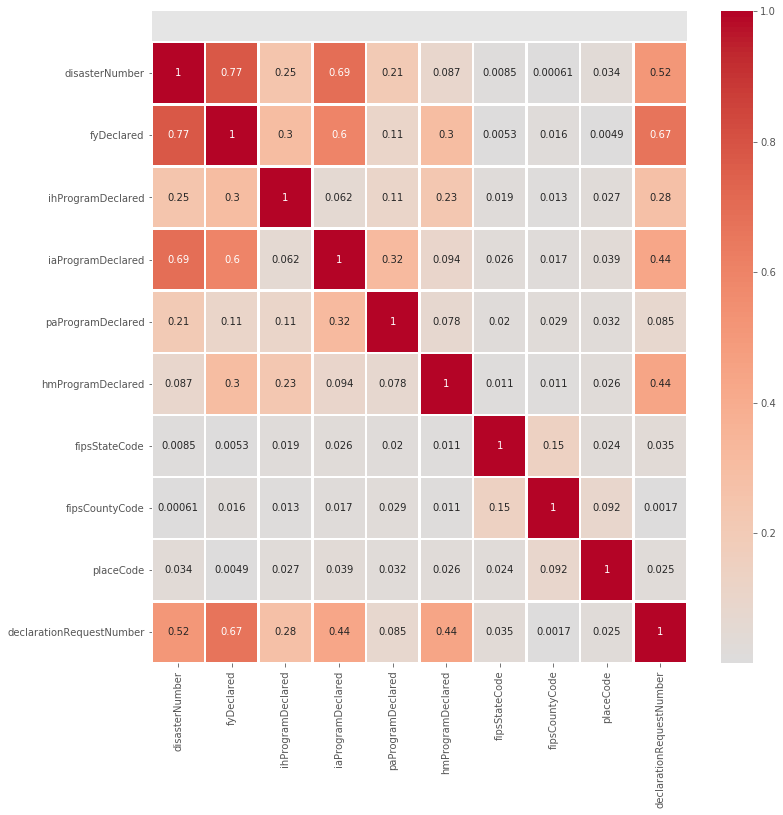

In [11]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.corr().abs(), center=0, annot=True, linewidths=1.5, cmap='coolwarm');
ax.set_ylim(len(df.corr())-0, -0.5)

# Scrub

In [12]:
df['femaDeclarationString'].value_counts()

DR-4522-ME    437
DR-1239-TX    257
EM-3458-TX    257
DR-4485-TX    257
EM-3261-TX    255
             ... 
FM-2648-NV      1
DR-1290-VA      1
DR-442-KS       1
DR-4448-SD      1
FM-2533-CA      1
Name: femaDeclarationString, Length: 4497, dtype: int64

In [13]:
df['disasterNumber'].value_counts()

4522    437
3458    257
4485    257
1239    257
3261    255
       ... 
2993      1
5010      1
2961      1
2929      1
2049      1
Name: disasterNumber, Length: 4497, dtype: int64

In [14]:
df['state'].value_counts()

TX    4651
MO    2670
VA    2460
KY    2416
OK    2278
GA    2239
LA    2131
FL    2027
NC    1965
PR    1825
IA    1823
MS    1691
KS    1682
AL    1619
AR    1588
TN    1522
MN    1498
IN    1451
CA    1443
NE    1423
NY    1421
ND    1301
OH    1281
IL    1268
SD    1251
PA    1226
WV    1218
ME    1004
WI     891
WA     862
SC     855
MI     791
CO     642
MT     586
NJ     567
OR     562
NM     495
MD     445
MA     389
ID     346
AZ     323
VT     314
NH     294
NV     271
AK     247
UT     241
CT     228
WY     128
RI     102
HI      95
VI      79
AS      75
MP      62
MH      53
DE      52
FM      31
DC      22
GU      19
PW       1
Name: state, dtype: int64

In [15]:
df['declarationType'].value_counts()

DR    40964
EM    17696
FM     1780
Name: declarationType, dtype: int64

In [16]:
df['declarationDate'].value_counts()

2020-03-13T20:00:00.000Z    2876
2020-03-13T19:00:00.000Z     566
1996-01-13T05:00:00.000Z     453
2020-04-04T17:15:00.000Z     437
2005-09-13T17:34:00.000Z     433
                            ... 
2014-07-10T10:23:00.000Z       1
1972-03-18T05:00:00.000Z       1
2005-08-02T06:58:00.000Z       1
2018-09-22T03:30:00.000Z       1
2004-07-21T06:34:00.000Z       1
Name: declarationDate, Length: 3849, dtype: int64

In [17]:
df['declarationDate'] = df['declarationDate'].str.split('T').str[0]

In [18]:
df['declarationDate'].value_counts()

2020-03-13    3683
2005-09-11     777
2020-04-04     738
2005-09-05     646
2005-09-13     615
              ... 
1992-06-09       1
1962-03-06       1
2015-06-17       1
2016-02-17       1
1998-02-13       1
Name: declarationDate, Length: 3118, dtype: int64

In [19]:
df['declarationDate'] = pd.to_datetime(df['declarationDate'])

In [20]:
# df['Declaration Day of Week'] = df['declarationDate'].dt.day_name()

In [21]:
#df['Declaration Year'] = df['declarationDate'].dt.year
#df['Declaration Month'] = df['declarationDate'].dt.month
#df['Declaration Day'] = df['declarationDate'].dt.day

In [22]:
#df = df.drop(columns=['declarationDate'], axis=1)

In [23]:
df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02T04:00:00.000Z,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,2f28952448e0a666d367ca3f854c81ec,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15T04:00:00.000Z,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,c5a1a4a1030d6730d9c562cdbe7c830f,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06T04:00:00.000Z,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,59c5483387ca13c6a3c1bc692f4860e1,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11T04:00:00.000Z,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,6bab17e16984fc75f61a8445df3e95d9,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11T04:00:00.000Z,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,e258e9dd25fac73939f59c8ffb5308f5,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e


In [24]:
df['fyDeclared'].value_counts()

2020    9243
2005    4661
2011    2684
2008    2456
2019    1902
        ... 
1960      13
1961      11
1953      10
1959       7
1958       6
Name: fyDeclared, Length: 69, dtype: int64

In [25]:
df['incidentType'].value_counts()

Severe Storm(s)     16957
Hurricane           11890
Flood               10389
Biological           7611
Snow                 3659
Fire                 3488
Severe Ice Storm     1990
Tornado              1464
Drought              1292
Coastal Storm         570
Freezing              301
Other                 297
Earthquake            226
Typhoon               130
Volcano                51
Fishing Losses         42
Mud/Landslide          31
Dam/Levee Break        13
Chemical                9
Toxic Substances        9
Tsunami                 9
Human Cause             7
Terrorist               5
Name: incidentType, dtype: int64

In [26]:
df['declarationTitle'].value_counts()

COVID-19 PANDEMIC               3928
SEVERE STORMS AND FLOODING      3810
COVID-19                        3683
SEVERE STORMS & FLOODING        3387
HURRICANE KATRINA EVACUATION    2602
                                ... 
CHESTNUT KNOB FIRE                 1
WEBER FIRE                         1
FLOOD & EROSION                    1
WOOD BRANCH VILLAGE FIRE           1
CHEVRON FIRE                       1
Name: declarationTitle, Length: 2136, dtype: int64

In [27]:
# We can combine COVID into one category as it's listed as two different categories
df['declarationTitle'].replace('COVID-19', 'COVID-19 PANDEMIC', inplace=True)
df['declarationTitle'].replace('SEVERE STORMS & FLOODING', 'SEVERE STORMS AND FLOODING', inplace=True)
df['declarationTitle'].value_counts()

COVID-19 PANDEMIC                         7611
SEVERE STORMS AND FLOODING                7197
HURRICANE KATRINA EVACUATION              2602
SEVERE WINTER STORM                       1935
SEVERE STORMS, TORNADOES, AND FLOODING    1849
                                          ... 
WEBER FIRE                                   1
ALICE CREEK FIRE                             1
WOOD BRANCH VILLAGE FIRE                     1
TX - SHEPPARD REESE FIRE - 09/04/00          1
CHEVRON FIRE                                 1
Name: declarationTitle, Length: 2134, dtype: int64

In [28]:
df['ihProgramDeclared'].value_counts()

0    50440
1    10000
Name: ihProgramDeclared, dtype: int64

In [29]:
df['iaProgramDeclared'].value_counts()

0    43253
1    17187
Name: iaProgramDeclared, dtype: int64

In [30]:
df['paProgramDeclared'].value_counts()

1    56309
0     4131
Name: paProgramDeclared, dtype: int64

In [31]:
df['hmProgramDeclared'].value_counts()

0    39029
1    21411
Name: hmProgramDeclared, dtype: int64

In [32]:
df['incidentBeginDate'].value_counts()

2020-01-20T19:00:00.000Z    7310
2005-08-29T04:00:00.000Z    1959
1993-03-13T05:00:00.000Z     771
1996-01-06T05:00:00.000Z     415
2005-11-27T05:00:00.000Z     380
                            ... 
1961-05-16T04:00:00.000Z       1
2014-05-05T04:00:00.000Z       1
2004-06-30T19:00:00.000Z       1
1999-08-27T04:00:00.000Z       1
1960-03-23T05:00:00.000Z       1
Name: incidentBeginDate, Length: 3364, dtype: int64

In [33]:
df['incidentBeginDate'] = df['incidentBeginDate'].str.split('T').str[0]

In [34]:
#df['incidentBeginDate'] = pd.to_datetime(df['incidentBeginDate'])

In [35]:
#df['Begin Day of Week'] = df['incidentBeginDate'].dt.day_name()

In [36]:
#df['Begin Incident Year'] = df['incidentBeginDate'].dt.year
#df['Begin Incident Month'] = df['incidentBeginDate'].dt.month
#df['Begin Incident Day'] = df['incidentBeginDate'].dt.day

In [37]:
#df = df.drop(columns=['incidentBeginDate'], axis=1)
#df.head()

In [38]:
df['incidentEndDate'].value_counts()

2005-10-01T12:55:00.000Z    2926
1993-03-17T05:00:00.000Z     635
1996-01-12T05:00:00.000Z     555
2017-09-21T03:59:00.000Z     321
2012-11-08T05:00:00.000Z     307
                            ... 
2000-09-06T02:15:00.000Z       1
2003-06-19T16:00:00.000Z       1
2002-06-28T22:00:00.000Z       1
1957-05-16T04:00:00.000Z       1
2011-09-13T03:59:00.000Z       1
Name: incidentEndDate, Length: 3174, dtype: int64

In [39]:
#df['incidentEndDate'] = df['incidentEndDate'].str.split('T').str[0]

In [40]:
#df['incidentEndDate'] = pd.to_datetime(df['incidentEndDate'])

In [41]:
#df['Incident End Day of Week'] = df['incidentEndDate'].dt.day_name()

In [42]:
#df['Incident End Year'] = df['incidentEndDate'].dt.year
#df['Incident End Month'] = df['incidentEndDate'].dt.month
#df['Incident End Day'] = df['incidentEndDate'].dt.day

In [43]:
#df = df.drop(columns=['incidentEndDate'], axis=1)
df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,2f28952448e0a666d367ca3f854c81ec,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,c5a1a4a1030d6730d9c562cdbe7c830f,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,59c5483387ca13c6a3c1bc692f4860e1,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,6bab17e16984fc75f61a8445df3e95d9,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,e258e9dd25fac73939f59c8ffb5308f5,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e


In [44]:
df['disasterCloseoutDate'].value_counts()

2020-04-22T03:59:00.000Z    674
2017-12-19T04:59:00.000Z    430
1994-06-30T04:00:00.000Z    410
1978-07-03T04:00:00.000Z    393
2001-09-18T04:00:00.000Z    390
                           ... 
1959-03-01T05:00:00.000Z      1
1981-07-30T04:00:00.000Z      1
1997-02-20T05:00:00.000Z      1
2006-05-18T04:00:00.000Z      1
2012-08-23T04:00:00.000Z      1
Name: disasterCloseoutDate, Length: 1755, dtype: int64

In [45]:
#df['disasterCloseoutDate'] = df['disasterCloseoutDate'].str.split('T').str[0]

In [46]:
#df['disasterCloseoutDate'] = pd.to_datetime(df['disasterCloseoutDate'])

In [47]:
#df['Disaster Close Day of Week'] = df['disasterCloseoutDate'].dt.day_name()

In [48]:
#df['Disaster Close Year'] = df['disasterCloseoutDate'].dt.year
#df['Disaster Close Month'] = df['disasterCloseoutDate'].dt.month
#df['Disaster Close Day'] = df['disasterCloseoutDate'].dt.day

In [49]:
#df = df.drop(columns=['disasterCloseoutDate'], axis=1)
df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,2f28952448e0a666d367ca3f854c81ec,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,c5a1a4a1030d6730d9c562cdbe7c830f,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,59c5483387ca13c6a3c1bc692f4860e1,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,6bab17e16984fc75f61a8445df3e95d9,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,e258e9dd25fac73939f59c8ffb5308f5,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e


In [50]:
df['fipsStateCode'].value_counts()

48    4651
29    2670
51    2460
21    2416
40    2278
13    2239
22    2131
12    2027
37    1965
72    1825
19    1823
28    1691
20    1682
1     1619
5     1588
47    1522
27    1498
18    1451
6     1443
31    1423
36    1421
38    1301
39    1281
17    1268
46    1251
42    1226
54    1218
23    1004
55     891
53     862
45     855
26     791
8      642
30     586
34     567
41     562
35     495
24     445
25     389
16     346
4      323
50     314
33     294
32     271
2      247
49     241
9      228
56     128
44     102
15      95
78      79
60      75
69      62
68      53
10      52
64      31
11      22
66      19
70       1
Name: fipsStateCode, dtype: int64

In [51]:
df['fipsCountyCode'].value_counts()

0      1333
3       994
5       962
7       949
9       933
       ... 
390       2
230       1
400       1
80        1
330       1
Name: fipsCountyCode, Length: 345, dtype: int64

In [52]:
df['placeCode'].value_counts()

99005    937
99009    917
99001    913
99007    896
99015    885
        ... 
72200      1
99400      1
99080      1
56240      1
48440      1
Name: placeCode, Length: 1109, dtype: int64

In [53]:
df['designatedArea'].value_counts()

Washington (County)       517
Jefferson (County)        471
Statewide                 465
Jackson (County)          455
Franklin (County)         445
                         ... 
T04 R09 WELS                1
T11 R12 WELS                1
T05 R19 WELS                1
Delaware-Muncie (TDSA)      1
T18 R12 WELS                1
Name: designatedArea, Length: 2769, dtype: int64

In [54]:
df['declarationRequestNumber'].value_counts()

20130    437
98062    257
20061    257
20080    257
5137     255
        ... 
8115       1
6066       1
6034       1
98175      1
2049       1
Name: declarationRequestNumber, Length: 4497, dtype: int64

In [55]:
df['hash'].value_counts()

a7263e8de3c4611d2ad1a2f2616ebc42    1
97cd7ba5e707987c8e6959250c94ed68    1
4bb4d34eb5fae327cd162f3e8a68da74    1
39acc22f996536c095a6f1770ac12110    1
ad9353e328afc1f098db014d207d12d9    1
                                   ..
fb6ad883a114e5cbe76aaaf4de22f4db    1
20bf4ebe61573deb0fccfb1a0a0ca4f2    1
b4031330233b7f645f770eb691e0d963    1
1b5a6c493a528f08a968c0c12ae435ec    1
245b7aad89e396afa37399c007e5f03e    1
Name: hash, Length: 60440, dtype: int64

In [56]:
df = df.drop(columns=['hash'], axis=1)
df

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60435,FM-5382-NV,5382,NV,FM,2020-11-18,2021,Fire,PINEHAVEN FIRE,0,0,1,1,2020-11-17,NaN,NaN,32,31,99031,Washoe (County),20323,2020-11-19T16:42:40.333Z,5fb6a0800eb5d36238b4d770
60436,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,15,99015,Del Norte (County),20302,2020-11-25T20:42:27.057Z,5fbec1b30eb5d36238660eac
60437,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,115,99115,Yuba (County),20302,2020-11-25T20:42:27.058Z,5fbec1b30eb5d36238660ebd
60438,DR-4566-DE,4566,DE,DR,2020-10-02,2021,Hurricane,TROPICAL STORM ISAIAS,0,0,1,1,2020-08-05,2020-08-08T03:59:00.000Z,NaN,10,3,99003,New Castle (County),20253,2020-12-02T21:41:43.367Z,5fc80a170eb5d36238431c13


In [57]:
# This column is just showing us when the data was last refreshed so we can drop
df['lastRefresh'].value_counts()

2020-10-05T14:21:20.707Z    6
2020-10-05T14:21:20.705Z    6
2020-10-05T14:21:20.703Z    5
2020-10-05T14:21:20.708Z    5
2020-10-05T14:21:20.709Z    5
                           ..
2020-10-05T14:21:38.584Z    1
2020-10-05T14:22:10.928Z    1
2020-10-05T14:22:06.632Z    1
2020-10-05T14:21:42.816Z    1
2020-10-05T14:21:59.524Z    1
Name: lastRefresh, Length: 51842, dtype: int64

In [58]:
df = df.drop(columns=['lastRefresh'], axis=1)
df

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,5f7b2be031a8c6681cfb434e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60435,FM-5382-NV,5382,NV,FM,2020-11-18,2021,Fire,PINEHAVEN FIRE,0,0,1,1,2020-11-17,NaN,NaN,32,31,99031,Washoe (County),20323,5fb6a0800eb5d36238b4d770
60436,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,15,99015,Del Norte (County),20302,5fbec1b30eb5d36238660eac
60437,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,115,99115,Yuba (County),20302,5fbec1b30eb5d36238660ebd
60438,DR-4566-DE,4566,DE,DR,2020-10-02,2021,Hurricane,TROPICAL STORM ISAIAS,0,0,1,1,2020-08-05,2020-08-08T03:59:00.000Z,NaN,10,3,99003,New Castle (County),20253,5fc80a170eb5d36238431c13


In [59]:
df['id'].value_counts()
# This column looks like individual ids that we won't need

5f7b2bfa31a8c6681cfc9413    1
5f7b2c2331a8c6681cff1d38    1
5f7b2bf831a8c6681cfc79e7    1
5f7b2bfe31a8c6681cfcca48    1
5f7b2bfe31a8c6681cfcc9cd    1
                           ..
5f7b2bf831a8c6681cfc7774    1
5f7b2be331a8c6681cfb5f18    1
5f7b2bef31a8c6681cfbf96b    1
5f7b2bf631a8c6681cfc5ea8    1
5f7b2c0b31a8c6681cfd9fc4    1
Name: id, Length: 60440, dtype: int64

In [60]:
#df = df.drop(columns=['id'], axis=1)
df

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,5f7b2be031a8c6681cfb434e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60435,FM-5382-NV,5382,NV,FM,2020-11-18,2021,Fire,PINEHAVEN FIRE,0,0,1,1,2020-11-17,NaN,NaN,32,31,99031,Washoe (County),20323,5fb6a0800eb5d36238b4d770
60436,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,15,99015,Del Norte (County),20302,5fbec1b30eb5d36238660eac
60437,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,115,99115,Yuba (County),20302,5fbec1b30eb5d36238660ebd
60438,DR-4566-DE,4566,DE,DR,2020-10-02,2021,Hurricane,TROPICAL STORM ISAIAS,0,0,1,1,2020-08-05,2020-08-08T03:59:00.000Z,NaN,10,3,99003,New Castle (County),20253,5fc80a170eb5d36238431c13


# Data Preparation (Preparing for Modeling)

In [61]:
# Finding the top 8 Natural Disasters
# We will make vizualizations of these
natdisasters = list(df['incidentType'].value_counts().head(8).index)
natdisasters

['Severe Storm(s)',
 'Hurricane',
 'Flood',
 'Biological',
 'Snow',
 'Fire',
 'Severe Ice Storm',
 'Tornado']

In [62]:
df = df[df['incidentType'].isin(natdisasters)]
df['incidentType'].value_counts()

Severe Storm(s)     16957
Hurricane           11890
Flood               10389
Biological           7611
Snow                 3659
Fire                 3488
Severe Ice Storm     1990
Tornado              1464
Name: incidentType, dtype: int64

In [63]:
df

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,5f7b2be031a8c6681cfb434e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60435,FM-5382-NV,5382,NV,FM,2020-11-18,2021,Fire,PINEHAVEN FIRE,0,0,1,1,2020-11-17,NaN,NaN,32,31,99031,Washoe (County),20323,5fb6a0800eb5d36238b4d770
60436,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,15,99015,Del Norte (County),20302,5fbec1b30eb5d36238660eac
60437,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,115,99115,Yuba (County),20302,5fbec1b30eb5d36238660ebd
60438,DR-4566-DE,4566,DE,DR,2020-10-02,2021,Hurricane,TROPICAL STORM ISAIAS,0,0,1,1,2020-08-05,2020-08-08T03:59:00.000Z,NaN,10,3,99003,New Castle (County),20253,5fc80a170eb5d36238431c13


In [64]:
# Make Date the index 
df['date'] = pd.to_datetime(df['declarationDate'])
df.set_index('date', inplace=True)
df

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
date,,,,,,,,,,,,,,,,,,,,,
1953-05-02,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,5f7b2be031a8c6681cfb4342
1953-05-15,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,5f7b2be031a8c6681cfb4345
1953-06-06,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,5f7b2be031a8c6681cfb4348
1953-06-11,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,5f7b2be031a8c6681cfb434b
1953-06-11,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,5f7b2be031a8c6681cfb434e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-18,FM-5382-NV,5382,NV,FM,2020-11-18,2021,Fire,PINEHAVEN FIRE,0,0,1,1,2020-11-17,NaN,NaN,32,31,99031,Washoe (County),20323,5fb6a0800eb5d36238b4d770
2020-10-17,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,15,99015,Del Norte (County),20302,5fbec1b30eb5d36238660eac
2020-10-17,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,115,99115,Yuba (County),20302,5fbec1b30eb5d36238660ebd


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57448 entries, 1953-05-02 to 2020-12-03
Data columns (total 21 columns):
femaDeclarationString       57448 non-null object
disasterNumber              57448 non-null int64
state                       57448 non-null object
declarationType             57448 non-null object
declarationDate             57448 non-null datetime64[ns]
fyDeclared                  57448 non-null int64
incidentType                57448 non-null object
declarationTitle            57448 non-null object
ihProgramDeclared           57448 non-null int64
iaProgramDeclared           57448 non-null int64
paProgramDeclared           57448 non-null int64
hmProgramDeclared           57448 non-null int64
incidentBeginDate           57448 non-null object
incidentEndDate             49347 non-null object
disasterCloseoutDate        41142 non-null object
fipsStateCode               57448 non-null int64
fipsCountyCode              57448 non-null int64
placeCode               

In [99]:
ts_natdisasters = df['natdisasters'].resample('A').count()['id']
ts_natdisasters.plot.line(color='red')
plt.title('Natural Disasters by Year')
plt.savefig('natdisasters-by-year')
plt.show()

KeyError: 'natdisasters'

In [66]:
# Severe Storm(s)

In [67]:
sstorms = df[df['incidentType'] == 'Severe Storm(s)']
sstorms

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
date,,,,,,,,,,,,,,,,,,,,,
1956-04-24,DR-56-NC,56,NC,DR,1956-04-24,1956,Severe Storm(s),SEVERE STORM,0,1,1,1,1956-04-24,1956-04-24T05:00:00.000Z,1957-09-01T04:00:00.000Z,37,0,0,Statewide,56009,5f7b2be031a8c6681cfb4410
1956-08-09,DR-61-PA,61,PA,DR,1956-08-09,1956,Severe Storm(s),STORM,0,1,1,1,1956-08-09,1956-08-09T04:00:00.000Z,1959-06-01T04:00:00.000Z,42,0,0,Statewide,56016,5f7b2be031a8c6681cfb4416
1956-05-21,DR-58-PA,58,PA,DR,1956-05-21,1956,Severe Storm(s),SEVERE STORM,0,1,1,1,1956-05-21,1956-05-21T04:00:00.000Z,1959-06-01T04:00:00.000Z,42,0,0,Statewide,56015,5f7b2be031a8c6681cfb441e
1960-07-15,DR-103-TX,103,TX,DR,1960-07-15,1960,Severe Storm(s),"HEAVY RAINS, HAIL, FLOODS & TORNADOES",0,1,1,1,1960-07-15,1960-07-15T04:00:00.000Z,1962-10-04T04:00:00.000Z,48,0,0,Statewide,60022,5f7b2be031a8c6681cfb4484
1960-07-15,DR-104-OK,104,OK,DR,1960-07-15,1960,Severe Storm(s),"HEAVY RAINS, HAIL, FLOODS & TORNADOES",0,1,1,1,1960-07-15,1960-07-15T04:00:00.000Z,1962-03-20T05:00:00.000Z,40,0,0,Statewide,60021,5f7b2be031a8c6681cfb44d4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-02,DR-4565-ND,4565,ND,DR,2020-10-02,2021,Severe Storm(s),SEVERE STORMS AND FLOODING,0,0,1,1,2020-06-29,2020-07-01T04:00:00.000Z,NaN,38,5,99005,Benson (County),20254,5f7b2c3131a8c6681cfffa45
2020-10-02,DR-4565-ND,4565,ND,DR,2020-10-02,2021,Severe Storm(s),SEVERE STORMS AND FLOODING,0,0,1,1,2020-06-29,2020-07-01T04:00:00.000Z,NaN,38,53,99053,McKenzie (County),20254,5f7b2c3131a8c6681cfffa5f
2020-10-02,DR-4565-ND,4565,ND,DR,2020-10-02,2021,Severe Storm(s),SEVERE STORMS AND FLOODING,0,0,1,1,2020-06-29,2020-07-01T04:00:00.000Z,NaN,38,61,99061,Mountrail (County),20254,5f7b2c3131a8c6681cfffa62


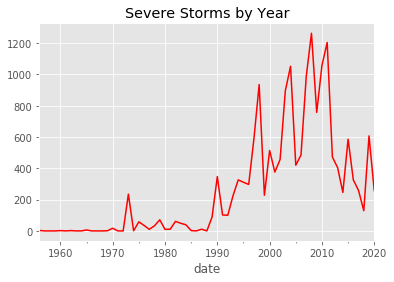

In [68]:
ts_sstorms = sstorms.resample('A').count()['id']
ts_sstorms.plot.line(color='red')
plt.title('Severe Storms by Year')
plt.savefig('severestorms-by-year')
plt.show()

In [69]:
hurricanes = df[df['incidentType'] =='Hurricane']
hurricanes

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
date,,,,,,,,,,,,,,,,,,,,,
1954-09-02,DR-22-MA,22,MA,DR,1954-09-02,1954,Hurricane,HURRICANES,0,1,1,1,1954-09-02,1954-09-02T04:00:00.000Z,1956-12-01T05:00:00.000Z,25,0,0,Statewide,54008,5f7b2be031a8c6681cfb437b
1954-10-07,DR-26-NY,26,NY,DR,1954-10-07,1955,Hurricane,HURRICANES,0,1,1,1,1954-10-07,1954-10-07T05:00:00.000Z,1956-12-01T05:00:00.000Z,36,0,0,Statewide,54012,5f7b2be031a8c6681cfb437e
1954-10-17,DR-29-SC,29,SC,DR,1954-10-17,1955,Hurricane,HURRICANE,0,1,1,1,1954-10-17,1954-10-17T05:00:00.000Z,1959-01-01T05:00:00.000Z,45,0,0,Statewide,54015,5f7b2be031a8c6681cfb4381
1954-10-17,DR-28-NC,28,NC,DR,1954-10-17,1955,Hurricane,HURRICANE,0,1,1,1,1954-10-17,1954-10-17T05:00:00.000Z,1959-01-01T05:00:00.000Z,37,0,0,Statewide,54014,5f7b2be031a8c6681cfb438d
1955-08-13,DR-37-NC,37,NC,DR,1955-08-13,1955,Hurricane,HURRICANES,0,1,1,1,1955-08-13,1955-08-13T04:00:00.000Z,1961-02-10T05:00:00.000Z,37,0,0,Statewide,55008,5f7b2be031a8c6681cfb4399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-11,EM-3551-FL,3551,FL,EM,2020-11-11,2021,Hurricane,HURRICANE ETA,0,0,1,0,2020-11-07,NaN,NaN,12,115,99115,Sarasota (County),20321,5fac7b670eb5d362384af402
2020-11-11,EM-3551-FL,3551,FL,EM,2020-11-11,2021,Hurricane,HURRICANE ETA,0,0,1,0,2020-11-07,NaN,NaN,12,83,99083,Marion (County),20321,5fac7b670eb5d362384af3a0
2020-11-11,EM-3551-FL,3551,FL,EM,2020-11-11,2021,Hurricane,HURRICANE ETA,0,0,1,0,2020-11-07,NaN,NaN,12,119,99119,Sumter (County),20321,5fac7b670eb5d362384af407


In [70]:
hurricanes.nunique()

femaDeclarationString         398
disasterNumber                398
state                          46
declarationType                 2
declarationDate               271
fyDeclared                     52
incidentType                    1
declarationTitle              140
ihProgramDeclared               2
iaProgramDeclared               2
paProgramDeclared               2
hmProgramDeclared               2
incidentBeginDate             191
incidentEndDate               235
disasterCloseoutDate          244
fipsStateCode                  46
fipsCountyCode                307
placeCode                     326
designatedArea               1796
declarationRequestNumber      398
id                          11890
dtype: int64

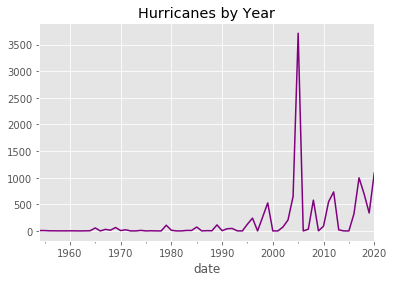

In [71]:
ts_hurricanes = hurricanes.resample('A').count()['id']
ts_hurricanes.plot.line(color='purple')
plt.title('Hurricanes by Year')
plt.savefig('hurricanes-by-year')
plt.show()

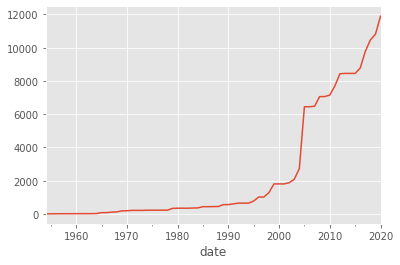

In [72]:
# Plotting the cumulation of hurricanes
ts_hurricanes.cumsum().plot()

In [73]:
# Flood

In [74]:
floods = df[df['incidentType'] =='Flood']
floods

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
date,,,,,,,,,,,,,,,,,,,,,
1953-06-06,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,5f7b2be031a8c6681cfb4348
1953-06-11,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,5f7b2be031a8c6681cfb434e
1953-06-19,DR-9-TX,9,TX,DR,1953-06-19,1953,Flood,FLOOD,0,1,1,1,1953-06-19,1953-06-19T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53010,5f7b2be031a8c6681cfb4351
1953-05-29,DR-3-LA,3,LA,DR,1953-05-29,1953,Flood,FLOOD,0,1,1,1,1953-05-29,1953-05-29T04:00:00.000Z,1960-02-01T05:00:00.000Z,22,0,0,Statewide,53005,5f7b2be031a8c6681cfb4354
1953-10-22,DR-12-FL,12,FL,DR,1953-10-22,1954,Flood,FLOOD,0,1,1,1,1953-10-22,1953-10-22T05:00:00.000Z,1956-05-01T04:00:00.000Z,12,0,0,Statewide,53015,5f7b2be031a8c6681cfb4360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-10,DR-4553-ND,4553,ND,DR,2020-07-10,2020,Flood,FLOODING,0,0,1,1,2020-04-01,2020-04-25T04:00:00.000Z,NaN,38,93,99093,Stutsman (County),20188,5f7b2c3131a8c6681cfff7a2
2020-07-10,DR-4553-ND,4553,ND,DR,2020-07-10,2020,Flood,FLOODING,0,0,1,1,2020-04-01,2020-04-25T04:00:00.000Z,NaN,38,77,99077,Richland (County),20188,5f7b2c3131a8c6681cfff7a5
2020-07-10,DR-4553-ND,4553,ND,DR,2020-07-10,2020,Flood,FLOODING,0,0,1,1,2020-04-01,2020-04-25T04:00:00.000Z,NaN,38,99,99099,Walsh (County),20188,5f7b2c3131a8c6681cfff7ae


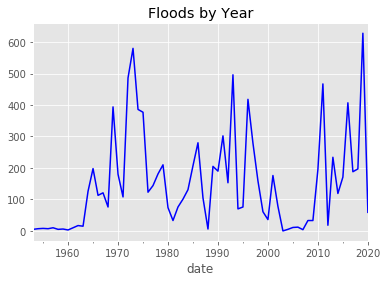

In [75]:
ts_flood = floods.resample('A').count()['id']
ts_flood.plot.line(color='blue')
plt.title('Floods by Year')
plt.savefig('floods-by-year')
plt.show()

In [76]:
# Biological

In [77]:
Biological = df[df['incidentType'] =='Biological']
Biological

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
date,,,,,,,,,,,,,,,,,,,,,
2020-03-13,EM-3427-WA,3427,WA,EM,2020-03-13,2020,Biological,COVID-19 PANDEMIC,0,0,1,0,2020-01-20,NaN,NaN,53,1,99001,Adams (County),20016,5f7b2c1b31a8c6681cfeabc4
2020-03-13,EM-3427-WA,3427,WA,EM,2020-03-13,2020,Biological,COVID-19 PANDEMIC,0,0,1,0,2020-01-20,NaN,NaN,53,11,99011,Clark (County),20016,5f7b2c1b31a8c6681cfeabd6
2020-03-13,EM-3427-WA,3427,WA,EM,2020-03-13,2020,Biological,COVID-19 PANDEMIC,0,0,1,0,2020-01-20,NaN,NaN,53,13,99013,Columbia (County),20016,5f7b2c1b31a8c6681cfeabda
2020-03-13,EM-3427-WA,3427,WA,EM,2020-03-13,2020,Biological,COVID-19 PANDEMIC,0,0,1,0,2020-01-20,NaN,NaN,53,7,99007,Chelan (County),20016,5f7b2c1b31a8c6681cfeabe0
2020-03-13,EM-3427-WA,3427,WA,EM,2020-03-13,2020,Biological,COVID-19 PANDEMIC,0,0,1,0,2020-01-20,NaN,NaN,53,9,99009,Clallam (County),20016,5f7b2c1b31a8c6681cfeabe8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-08,DR-4545-FL,4545,FL,DR,2020-05-08,2020,Biological,COVID-19 PANDEMIC,0,0,1,0,2020-01-20,NaN,NaN,12,0,24330,Fort Pierce Indian Reservation,20175,5f7b2c3131a8c6681cfff5e8
2020-05-08,DR-4545-FL,4545,FL,DR,2020-05-08,2020,Biological,COVID-19 PANDEMIC,0,0,1,0,2020-01-20,NaN,NaN,12,0,33260,Immokalee Indian Reservation,20175,5f7b2c3131a8c6681cfff5f0
2020-05-08,DR-4545-FL,4545,FL,DR,2020-05-08,2020,Biological,COVID-19 PANDEMIC,0,0,1,0,2020-01-20,NaN,NaN,12,0,65033,Seminole Indian Trust Lands,20175,5f7b2c3131a8c6681cfff5f5


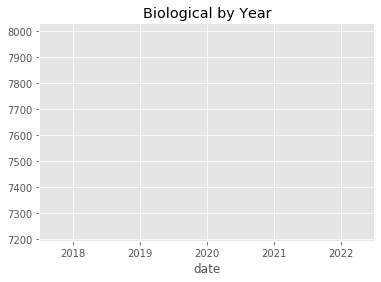

In [79]:
ts_Biological = Biological.resample('A').count()['id']
ts_Biological.plot.line(color='orange')
plt.title('Biological by Year')
plt.savefig('Biological-by-year')
plt.show()

In [ ]:
# Snow

In [80]:
Snow = df[df['incidentType'] =='Snow']
Snow

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
date,,,,,,,,,,,,,,,,,,,,,
1964-12-18,DR-182-MT,182,MT,DR,1964-12-18,1965,Snow,SEVERE WINTER STORM,0,1,1,1,1964-12-18,1964-12-18T05:00:00.000Z,1966-01-07T05:00:00.000Z,30,0,0,Statewide,64029,5f7b2be131a8c6681cfb45ec
1972-04-05,DR-330-MI,330,MI,DR,1972-04-05,1972,Snow,SEVERE STORM & FREEZING,0,0,1,0,1972-04-05,1972-04-05T05:00:00.000Z,1974-03-26T04:00:00.000Z,26,5,99005,Allegan (County),72020,5f7b2be431a8c6681cfb6892
1972-04-05,DR-330-MI,330,MI,DR,1972-04-05,1972,Snow,SEVERE STORM & FREEZING,0,0,1,0,1972-04-05,1972-04-05T05:00:00.000Z,1974-03-26T04:00:00.000Z,26,15,99015,Barry (County),72020,5f7b2be431a8c6681cfb6897
1972-04-05,DR-330-MI,330,MI,DR,1972-04-05,1972,Snow,SEVERE STORM & FREEZING,0,0,1,0,1972-04-05,1972-04-05T05:00:00.000Z,1974-03-26T04:00:00.000Z,26,37,99037,Clinton (County),72020,5f7b2be431a8c6681cfb68b5
1972-04-05,DR-330-MI,330,MI,DR,1972-04-05,1972,Snow,SEVERE STORM & FREEZING,0,0,1,0,1972-04-05,1972-04-05T05:00:00.000Z,1974-03-26T04:00:00.000Z,26,45,99045,Eaton (County),72020,5f7b2be431a8c6681cfb68bb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-19,DR-4379-MA,4379,MA,DR,2018-07-19,2018,Snow,SEVERE WINTER STORM AND SNOWSTORM,0,0,1,1,2018-03-13,2018-03-15T03:59:00.000Z,NaN,25,25,99025,Suffolk (County),18060,5f7b2c2a31a8c6681cff8e3d
2018-07-19,DR-4379-MA,4379,MA,DR,2018-07-19,2018,Snow,SEVERE WINTER STORM AND SNOWSTORM,0,0,1,1,2018-03-13,2018-03-15T03:59:00.000Z,NaN,25,21,99021,"Norfolk (County)(in PMSA 1120,1200,6060)",18060,5f7b2c2a31a8c6681cff8e3f
2018-07-19,DR-4379-MA,4379,MA,DR,2018-07-19,2018,Snow,SEVERE WINTER STORM AND SNOWSTORM,0,0,1,1,2018-03-13,2018-03-15T03:59:00.000Z,NaN,25,27,99027,"Worcester (County) (in (P)MSA 1120,2600,9240)",18060,5f7b2c2a31a8c6681cff8e4e


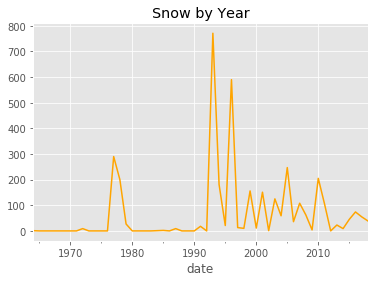

In [82]:
ts_Snow = Snow.resample('A').count()['id']
ts_Snow.plot.line(color='orange')
plt.title('Snow by Year')
plt.savefig('Snow-by-year')
plt.show()

In [ ]:
#'Fire'

In [83]:
Fire = df[df['incidentType'] =='Fire']
Fire

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
date,,,,,,,,,,,,,,,,,,,,,
1953-07-02,DR-11-NH,11,NH,DR,1953-07-02,1953,Fire,FOREST FIRE,0,1,1,1,1953-07-02,1953-07-02T04:00:00.000Z,1956-02-01T05:00:00.000Z,33,0,0,Statewide,53011,5f7b2be031a8c6681cfb435d
1956-12-29,DR-65-CA,65,CA,DR,1956-12-29,1957,Fire,FOREST FIRE,0,1,1,1,1956-12-29,1956-12-29T05:00:00.000Z,1959-04-01T05:00:00.000Z,6,0,0,Statewide,56018,5f7b2be031a8c6681cfb4426
1960-07-22,DR-105-ID,105,ID,DR,1960-07-22,1960,Fire,FIRES,0,1,1,1,1960-07-22,1960-07-22T04:00:00.000Z,1961-09-20T04:00:00.000Z,16,0,0,Statewide,60019,5f7b2be031a8c6681cfb44e0
1961-11-16,DR-119-CA,119,CA,DR,1961-11-16,1962,Fire,FIRE (LOS ANGELES COUNTY),0,1,1,1,1961-11-16,1961-11-16T05:00:00.000Z,1963-08-01T04:00:00.000Z,6,0,0,Statewide,61019,5f7b2be031a8c6681cfb4529
1967-08-30,DR-231-ID,231,ID,DR,1967-08-30,1967,Fire,FOREST FIRES,0,1,1,0,1967-08-30,1967-08-30T04:00:00.000Z,1970-06-17T04:00:00.000Z,16,9,99009,Benewah (County),67025,5f7b2be231a8c6681cfb5401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-22,DR-4558-CA,4558,CA,DR,2020-08-22,2020,Fire,WILDFIRES,1,0,1,1,2020-08-14,2020-09-27T03:59:00.000Z,NaN,6,99,99099,Stanislaus (County),20239,5fade9170eb5d36238058ee3
2020-11-18,FM-5382-NV,5382,NV,FM,2020-11-18,2021,Fire,PINEHAVEN FIRE,0,0,1,1,2020-11-17,NaN,NaN,32,31,99031,Washoe (County),20323,5fb6a0800eb5d36238b4d770
2020-10-17,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,15,99015,Del Norte (County),20302,5fbec1b30eb5d36238660eac


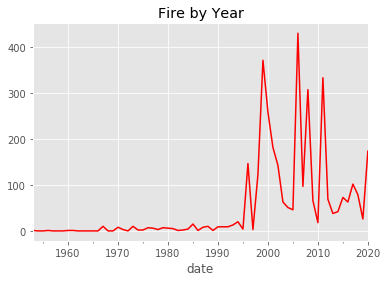

In [84]:
ts_Fire = Fire.resample('A').count()['id']
ts_Fire.plot.line(color='red')
plt.title('Fire by Year')
plt.savefig('Fire-by-year')
plt.show()

In [ ]:
#'Severe Ice Storm'

In [85]:
Ice = df[df['incidentType'] =='Severe Ice Storm']
Ice

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
date,,,,,,,,,,,,,,,,,,,,,
1968-02-10,DR-234-NC,234,NC,DR,1968-02-10,1968,Severe Ice Storm,SEVERE ICE STORM,0,1,1,0,1968-02-10,1968-02-10T05:00:00.000Z,1969-09-17T04:00:00.000Z,37,49,99049,Craven (County),68004,5f7b2be231a8c6681cfb54ca
1968-02-10,DR-234-NC,234,NC,DR,1968-02-10,1968,Severe Ice Storm,SEVERE ICE STORM,0,1,1,0,1968-02-10,1968-02-10T05:00:00.000Z,1969-09-17T04:00:00.000Z,37,15,99015,Bertie (County),68004,5f7b2be231a8c6681cfb54d2
1968-02-10,DR-234-NC,234,NC,DR,1968-02-10,1968,Severe Ice Storm,SEVERE ICE STORM,0,1,1,0,1968-02-10,1968-02-10T05:00:00.000Z,1969-09-17T04:00:00.000Z,37,65,99065,Edgecombe (County),68004,5f7b2be231a8c6681cfb54d6
1968-02-10,DR-234-NC,234,NC,DR,1968-02-10,1968,Severe Ice Storm,SEVERE ICE STORM,0,1,1,0,1968-02-10,1968-02-10T05:00:00.000Z,1969-09-17T04:00:00.000Z,37,13,99013,Beaufort (County),68004,5f7b2be231a8c6681cfb54d7
1968-02-10,DR-234-NC,234,NC,DR,1968-02-10,1968,Severe Ice Storm,SEVERE ICE STORM,0,1,1,0,1968-02-10,1968-02-10T05:00:00.000Z,1969-09-17T04:00:00.000Z,37,85,99085,Harnett (County),68004,5f7b2be231a8c6681cfb54e1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,DR-4304-KS,4304,KS,DR,2017-02-24,2017,Severe Ice Storm,SEVERE WINTER STORM,0,0,1,1,2017-01-13,2017-01-16T11:00:00.000Z,NaN,20,195,99195,Trego (County),17016,5f7b2c2831a8c6681cff7879
2017-02-24,DR-4304-KS,4304,KS,DR,2017-02-24,2017,Severe Ice Storm,SEVERE WINTER STORM,0,0,1,1,2017-01-13,2017-01-16T11:00:00.000Z,NaN,20,185,99185,Stafford (County),17016,5f7b2c2831a8c6681cff787f
2017-02-24,DR-4304-KS,4304,KS,DR,2017-02-24,2017,Severe Ice Storm,SEVERE WINTER STORM,0,0,1,1,2017-01-13,2017-01-16T11:00:00.000Z,NaN,20,175,99175,Seward (County),17016,5f7b2c2831a8c6681cff788f


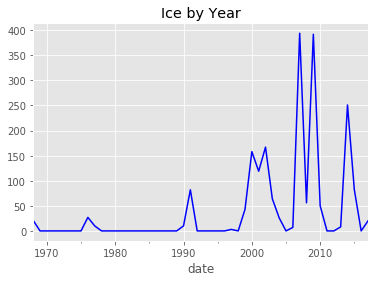

In [87]:
ts_Ice = Ice.resample('A').count()['id']
ts_Ice.plot.line(color='blue')
plt.title('Ice by Year')
plt.savefig('Ice-by-year')
plt.show()

In [ ]:
#'Tornado'

In [88]:
Tornado = df[df['incidentType'] =='Tornado']
Tornado

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
date,,,,,,,,,,,,,,,,,,,,,
1953-05-02,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,5f7b2be031a8c6681cfb4342
1953-05-15,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,5f7b2be031a8c6681cfb4345
1953-06-11,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,5f7b2be031a8c6681cfb434b
1953-06-02,DR-4-MI,4,MI,DR,1953-06-02,1953,Tornado,TORNADO,0,1,1,1,1953-06-02,1953-06-02T04:00:00.000Z,1956-02-01T05:00:00.000Z,26,0,0,Statewide,53004,5f7b2be031a8c6681cfb4357
1953-06-09,DR-6-MI,6,MI,DR,1953-06-09,1953,Tornado,TORNADO,0,1,1,1,1953-06-09,1953-06-09T04:00:00.000Z,1956-03-30T05:00:00.000Z,26,0,0,Statewide,53007,5f7b2be031a8c6681cfb435a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-10,DR-4556-AR,4556,AR,DR,2020-07-10,2020,Tornado,SEVERE STORMS AND STRAIGHT-LINE WINDS,0,0,1,1,2020-04-12,2020-04-13T03:59:00.000Z,NaN,5,79,99079,Lincoln (County),20196,5f7b2c3131a8c6681cfff81a
2020-07-10,DR-4556-AR,4556,AR,DR,2020-07-10,2020,Tornado,SEVERE STORMS AND STRAIGHT-LINE WINDS,0,0,1,1,2020-04-12,2020-04-13T03:59:00.000Z,NaN,5,95,99095,Monroe (County),20196,5f7b2c3131a8c6681cfff81c
2020-07-10,DR-4556-AR,4556,AR,DR,2020-07-10,2020,Tornado,SEVERE STORMS AND STRAIGHT-LINE WINDS,0,0,1,1,2020-04-12,2020-04-13T03:59:00.000Z,NaN,5,103,99103,Ouachita (County),20196,5f7b2c3131a8c6681cfff81f


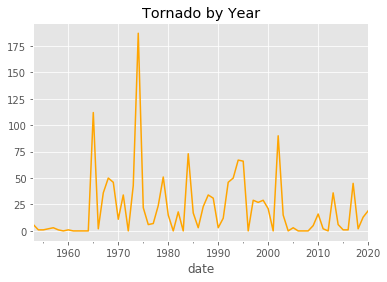

In [89]:
ts_Tornado = Tornado.resample('A').count()['id']
ts_Tornado.plot.line(color='orange')
plt.title('Tornado by Year')
plt.savefig('Tornado-by-year')
plt.show()

In [93]:
ar_model = ARMA(df, order = (1, 0)).fit()
ar_model.summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).